In [1]:
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
set_session(tf.Session(config=config))

import matplotlib.pyplot as plt
from datetime import datetime

# keras functions
from keras import callbacks
from keras import preprocessing
from keras.preprocessing import image

# our libraries
from preprocessing import *

from cnn_models import *
from evaluate import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape, e.g. (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth (after properly discretizing by it patch-wise).

### - Load data

In [2]:
# Loaded a set of images
n = 12

imgs, gt_imgs = load_images(n)
imgs[0].shape, gt_imgs[0].shape

Loading 12 images


((400, 400, 3), (400, 400))

### - Convert the data to the correct format
We reshape each input to fulfill the requirements of the tensorflow library. 

In [3]:
# set predict_patch_width in accordance to the model: the model is classifying 
# patch-wise, patches of size predict_patch_width x predict_patch_width
predict_patch_width = 8

X, Y = images_to_XY(imgs, gt_imgs, predict_patch_width=predict_patch_width)
X.shape, Y.shape

((12, 400, 400, 3), (12, 50, 50, 2))

### - For now avoid cross validation, just split the datasest in test and train. 

In [4]:
test_ratio = 0.5

train, test = split_train_test(X, Y, test_ratio=test_ratio, seed=1)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape 

((6, 400, 400, 3), (6, 50, 50, 2), (6, 400, 400, 3), (6, 50, 50, 2))

In [5]:
# # check it makes sense (show the i-th input of set_)
# i = 0
# set_ = test

# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].imshow(set_.Y[i, :, :, 1], cmap='gray')
# axs[1].imshow(set_.X[i, :, :])

### - Build the CNN model
Choose one of the models you defined and the compile it.

In [6]:
model = model2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    11648     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 48)    38448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 48)    57648     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 48)    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 48)    57648     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 48)    57648     
__________

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### - Fit the model on the train data

In [8]:
# some callbacks example: 

# create a list of callbacks we want to use during training
# # a callback to store epoch results to a csv file
# filename='model_train_new.csv'
# csv_log = callbacks.CSVLogger(filename, separator=',', append=False)

# # a callback to stob before doing the predefined number of epochs (stop before overfitting the data)
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

# # a callback to save the best model (best model = the one with the lowest 'monitor' variable)
# filepath = "best-weights-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # callbacks_list = [csv_log,early_stopping,checkpoint]

In [9]:
#building a datagenerator
import keras as ks
datagen = ks.preprocessing.image.ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.,
    height_shift_range=0.,
    zoom_range=0,
    fill_mode='wrap',
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen = ks.preprocessing.image.ImageDataGenerator()
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train.X)



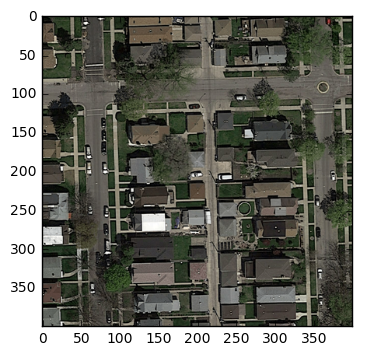

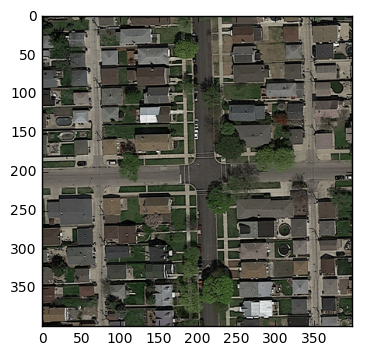

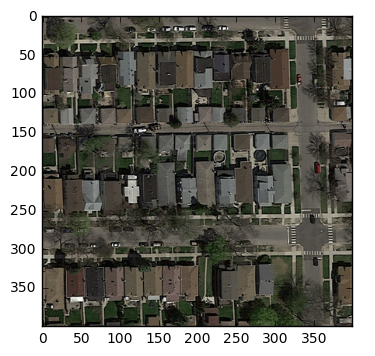

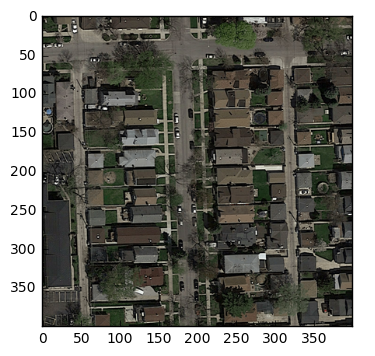

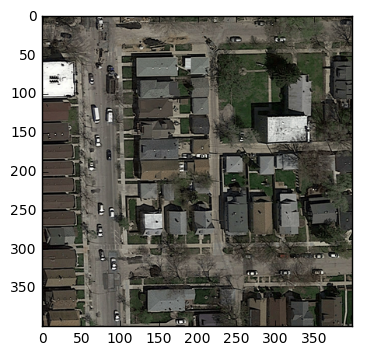

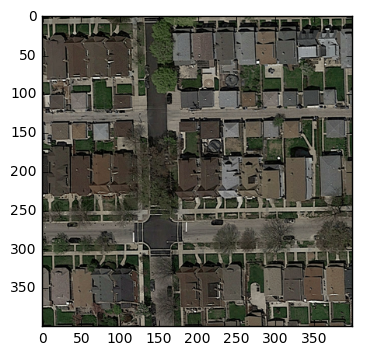

In [10]:
#checking that the flow is working
batches = datagen.flow(train.X,train.Y,batch_size=32)
x_batch, y_batch = next(batches)

for i in range (0,6):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()
    

In [11]:
# use just the callback to save the best model (best model = the one with the best 'monitor' variable)
filepath = "..\\models\\" + str('{0:%Y-%m-%d_%H%M%S}'.format(datetime.now()))+"_best-weights.hdf5" # -{epoch:03d}-{loss:.4f}-{acc:.4f}
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# either validation_data=(test.X, test.Y) or validation_split=0.2
num_epoch = 40
num_steps = 10
hist = model.fit_generator(
    datagen.flow(train.X, train.Y, batch_size = 32), 
    steps_per_epoch =num_steps,
    epochs = num_epoch, 
    verbose = 1,
    validation_data = datagen.flow(test.X, test.Y, batch_size=32), 
    validation_steps = num_steps,
    callbacks = callbacks_list
)

Epoch 1/40
 1/10 [==>...........................] - ETA: 13s - loss: 0.5750 - acc: 0.7443 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00

#### Plot the accuracy and the loss obtained during training

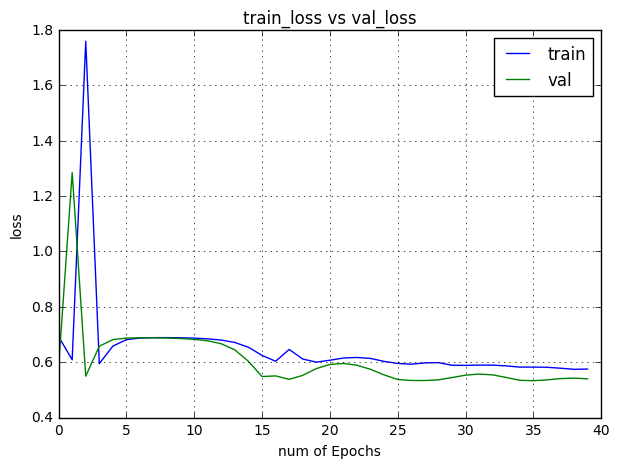

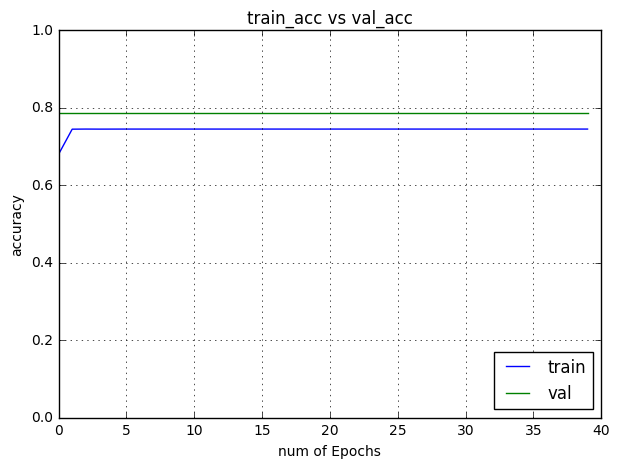

In [12]:
plot_history(hist)

#### Display the output of a specific layer

feature_maps (output of layer 7): (100, 100, 48)


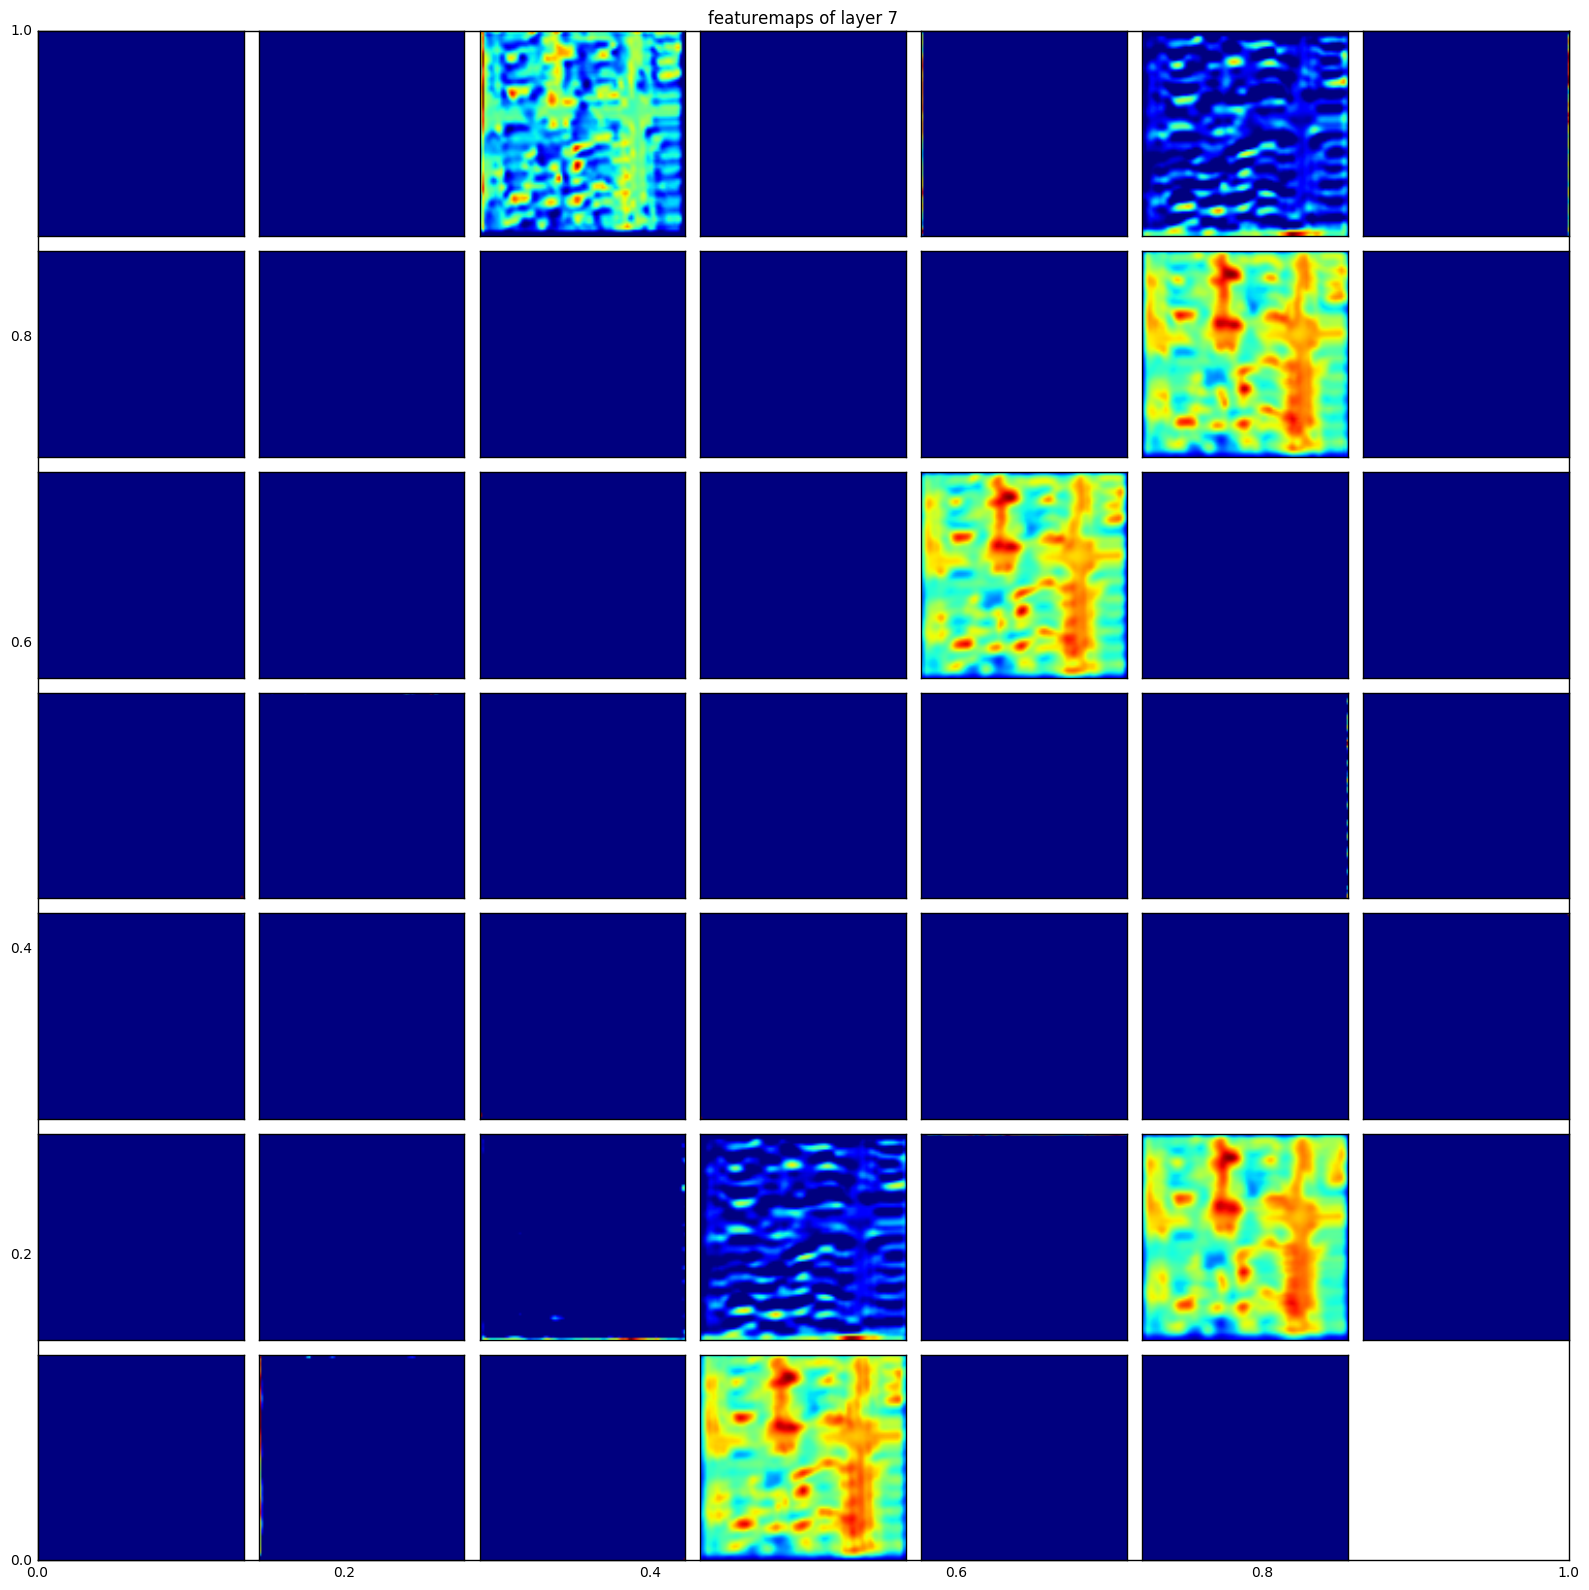

In [13]:
# choose a layer and an image 
image = test.X[0]
layer_num = 7

show_layer_output(model, image, layer_num, filename="") # pass a filename if you want to store the image to file 

### - Evaluate the model on the test data

                precision    recall  f1-score   support

0 (background)       0.74      1.00      0.85     11165
      1 (road)       0.00      0.00      0.00      3835

   avg / total       0.55      0.74      0.64     15000

Confusion matrix, without normalization


C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


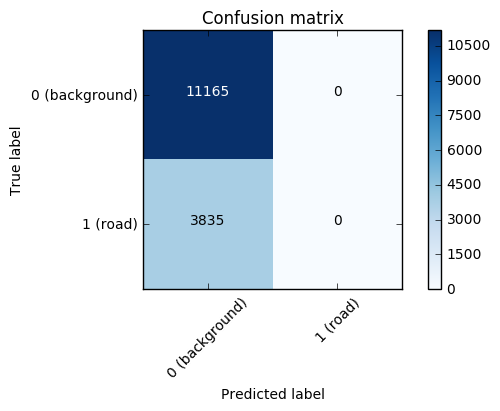

Normalized confusion matrix


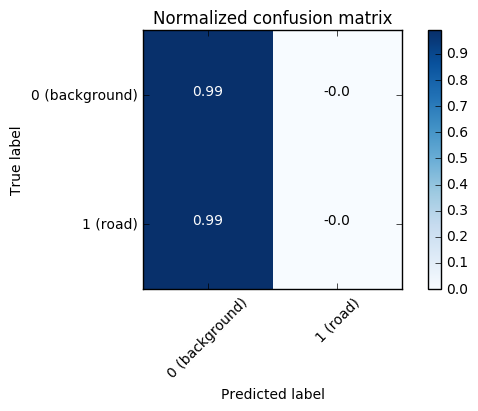

In [14]:
# check the performance on train or test
set_ = train

evaluate_model(model, set_.X, set_.Y)

### - Show a prediction

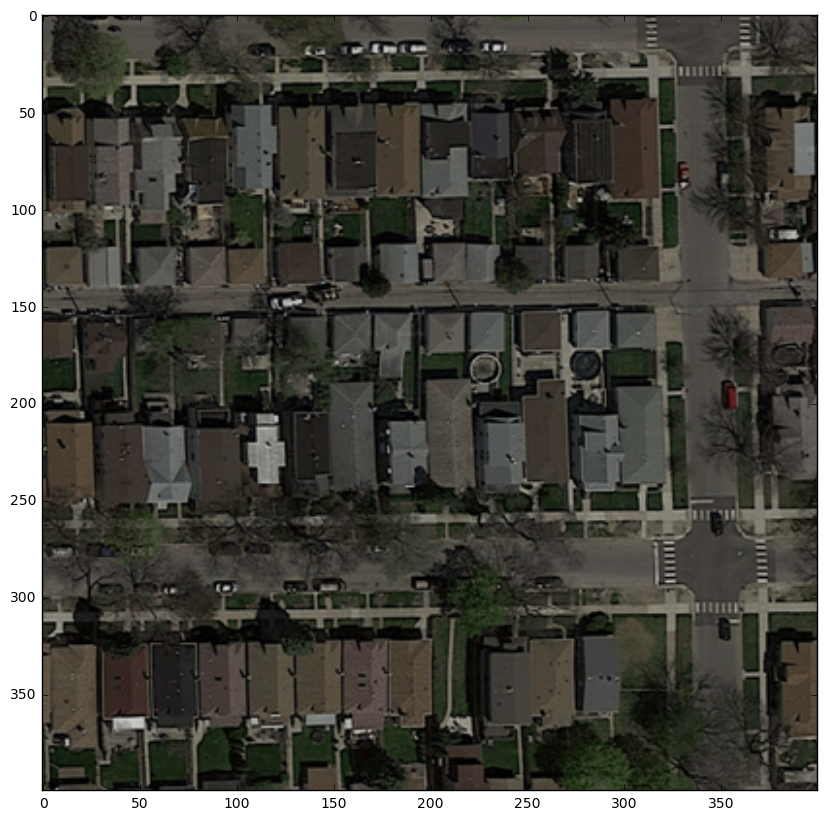

In [15]:
# choose an image to predict (or part of it)
img = train.X[3][:, :]

display_prediction(model, img, ax=None)

### - Save/load model

In [16]:
# # Saving and loading model and weights
# from keras.models import model_from_json
# from keras.models import load_model

# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

# model.save('model.hdf5')
# loaded_model=load_model('model.hdf5')

### - Others

In [17]:
print(
    "-get configurations:", "\n",
    model.get_config(), "\n",
    model.layers[0].get_config(), "\n",

    "\n-get shapes", "\n",
    model.layers[0].input_shape, "\n",
    model.layers[0].output_shape, "\n",
    
    "\n-get weights", "\n",
    model.layers[0].get_weights()[0].shape, "\n",
    
    "\n-check if trainable", "\n",
    model.layers[0].trainable, "\n", # you can set this to false to "freeze" a layer
)

-get configurations: 
 [{'config': {'filters': 32, 'bias_initializer': {'config': {}, 'class_name': 'Zeros'}, 'data_format': 'channels_last', 'use_bias': True, 'kernel_size': (11, 11), 'activation': 'relu', 'kernel_constraint': None, 'kernel_regularizer': None, 'dtype': 'float32', 'name': 'conv2d_1', 'trainable': True, 'strides': (1, 1), 'batch_input_shape': (None, None, None, 3), 'activity_regularizer': None, 'kernel_initializer': {'config': {'scale': 1.0, 'seed': None, 'mode': 'fan_avg', 'distribution': 'uniform'}, 'class_name': 'VarianceScaling'}, 'padding': 'same', 'bias_constraint': None, 'bias_regularizer': None, 'dilation_rate': (1, 1)}, 'class_name': 'Conv2D'}, {'config': {'trainable': True, 'seed': None, 'noise_shape': None, 'rate': 0.25, 'name': 'dropout_1'}, 'class_name': 'Dropout'}, {'config': {'filters': 48, 'bias_initializer': {'config': {}, 'class_name': 'Zeros'}, 'data_format': 'channels_last', 'use_bias': True, 'kernel_regularizer': None, 'activation': 'relu', 'kernel_